The script provides the code for the paper of co-crystal discovery and is separated into the following parts:


1. Importing the datasets from CSD and ZINC 15 (all the features are implemented and no feature engineering is required).
2. A deep neural network for one class classification was built using Pytorch library. The deepSVDD architecture was adapted from '**Deep One-Class Classification**, Ruff et al,Proceedings of the 35th International Conference on Machine Learning, 393-4402, 2018,80. The Attention-based autoencoder implemented was adapted from '**Set Transformer: A Framework for Attention-based Permutation-Invariant Neural Networks**, Lee et al, Proceedings of the 36th International Conference on Machine Learning, 3744-3753,2019.
3. The evaluation of the network is performed with k-fold cross validation on measuring the True Positive Rate.
4. The trained model is used for scoring the labeled and unlabeled data.
5. The molecular pairs are visualized.



# Import the relevant datasets

In [1]:
# Import the basic libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from scipy.spatial.distance import squareform
from matplotlib import cm
import itertools
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}
print(dict1['comb1'])

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [4]:
# Dictionary where each smiles is associated with its ZINC Identifier
zinc_smiles=pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/zinc_smiles.csv')
v2= zinc_smiles.Identifier.str.strip()
k2=zinc_smiles['smiles'].values
zinc_dict= {key:value for key, value in zip(k2, v2)}

In [5]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 987 kB 4.7 MB/s 
     |████████████████████████████████| 59 kB 3.6 MB/s 
     |████████████████████████████████| 98 kB 6.7 MB/s 
     |████████████████████████████████| 269 kB 19.8 MB/s 
     |████████████████████████████████| 90 kB 9.3 MB/s 
     |████████████████████████████████| 95 kB 2.5 MB/s 
     |████████████████████████████████| 90 kB 8.1 MB/s 
     |████████████████████████████████| 155 kB 22.7 MB/s 
     |████████████████████████████████| 47 kB 4.6 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 100 kB 8.8 MB/s 
     |████████████████████████████████| 1.3 MB 24.5 MB/s 


In [6]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

link1='hhttps://drive.google.com/open?id=1GXCi-JWtsPjFWe25E_jUNYS1iYUZXiGz' 
fluff, id = link1.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('coformers1.csv') 
dataset1=pd.read_csv('coformers1.csv') 
print(dataset1.shape)

1GXCi-JWtsPjFWe25E_jUNYS1iYUZXiGz
(1722, 1859)


In [7]:
# Import the dataset which contains all the molecules that constitute the second coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

link2='https://drive.google.com/open?id=1B9vUBhctWnJIC__-vYNPAIEJ9Y-H7vkj'
fluff, id = link2.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('coformers2.csv') 
dataset2=pd.read_csv('coformers2.csv')
print(dataset2.shape)

1B9vUBhctWnJIC__-vYNPAIEJ9Y-H7vkj
(1722, 1859)


In [8]:
df1=dataset1.iloc[:,2:]
df1 = df1.fillna(df1.mean())
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(df2.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]

In [9]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset11, dataset22], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()


df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)
labelled

In [12]:
# Generate the unknown dataset (unlabelled)

# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data_test/unlabelled_dragon (5).csv')

val = unlabeled['NAME'].values
length = len(val)
print(length)
unlabeled=unlabeled.loc[:, (unlabeled != 0).any(axis=0)]


pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)

pairs = pd.DataFrame(no_dups)
keys = unlabeled['NAME'].values
values = unlabeled.iloc[:, 1:].values

d = {key:value for key, value in zip(keys, values)}
print(len(d['ZINC000000354958']))

209
2008


In [13]:
mol1_data= list()

for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 1:].columns.values)   

mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 1:].columns.values) 

In [14]:
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(df1.mean())
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(0)

unlab=pd.concat([pairs[0], pairs[1]], axis=1)
final_1 = final_1.replace({'#NUM!': 0})
final_2 = final_2.replace({'#NUM!': 0})

final_11=final_1[dataset1.iloc[:,2:].columns.values]

final_22=final_2[dataset1.iloc[:,2:].columns.values]


In [15]:
#final_1.to_pickle('/content/drive/My Drive/cocrystal_design-master/data/final_1.plk')
#final_2.to_pickle('/content/drive/My Drive/cocrystal_design-master/data/final_2.plk')

In [16]:
# Standarize the unlabeled data based on the labelled
final_1_scaled = pd.DataFrame(X_scaler.transform(final_11))
final_2_scaled = pd.DataFrame(X_scaler.transform(final_22))
uf=pd.concat([final_1_scaled, final_2_scaled], axis =1)

In [17]:
# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11.shape[0]+1):
  comb.append('comb%s' % i)

uf_tot=pd.concat([pd.DataFrame(comb, columns=['comb']),final_11, final_22 ], axis=1)

keys1 = uf_tot['comb'].values
values1 =  uf_tot.iloc[:, 1:].values

dii={key:value for key, value in zip(keys1, values1)}

In [18]:

zinc_smiles = pd.read_csv('/content/drive/My Drive/cocrystal_design-master/data/zinc_smiles.csv', sep=',')

ke= zinc_smiles.Identifier.str.strip()
v=zinc_smiles['smiles'].values
my_dict= {key:value for key, value in zip(ke, v)}

i=list()
for l in pairs[0]:  
  #print(my_dict[l])
  i.append(my_dict[l])

k=list()
for m in pairs[1]:
  k.append(my_dict[m])

dictionary = pd.concat([ uf_tot['comb'], pd.DataFrame(i, columns=['smiles1']), pd.DataFrame(k, columns=['smiles2']), pd.DataFrame(pairs[0]), pd.DataFrame(pairs[1])], axis=1)

In [19]:
# Dictionary assinign to each combination number the smiles of the molecular pairs
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}
print(dict1['comb1'])

# Dictionary where each smiles is associated with its ZINC Identifier
v2= zinc_smiles.Identifier.str.strip()
k2=zinc_smiles['smiles'].values
zinc_dict= {key:value for key, value in zip(k2, v2)}

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [20]:
# Remove duplicate structures that might exist in both the labelled and unlabelled dataset
df_tota= pd.concat([pd.DataFrame(df['Identifier'].values, columns=['comb']), pd.DataFrame(df.iloc[:, 1:].values) ],axis=1)
uf_tota=pd.concat([pd.DataFrame(comb, columns=['comb']), pd.DataFrame(uf.values)],axis=1) 

check=pd.concat([df_tota, uf_tota], axis=0)
check.shape
c=check.drop_duplicates(subset=check.columns.values[1:] ,keep='first', inplace=False)
df1=c.iloc[:3476, :]
uf1=c.iloc[3476:, :]
val = pd.concat([uf_tota, uf1], axis=0)
v= val['comb'].drop_duplicates(keep=False, inplace=False)
df__=df1.iloc[:, 1:]
uf_=uf1.iloc[:, 1:]

In [21]:
# Print the first lines of whole unlabelled dataset
uf_final= pd.DataFrame(uf_tota.values, columns=df.columns.values)
uf_final.head()

,Identifier,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,nAT,nSK,nBT,nBO,nBM,SCBO,RBN,RBF,nDB,nTB,nAB,nH,nC,nN,nO,nP,nS,nF,nCL,nBR,nHM,nHet,nX,H%,C%,N%,O%,X%,nCsp3,...,Ui,Hy,AMR,TPSA(NO),TPSA(Tot),MLOGP,MLOGP2,ALOGP,ALOGP2,SAtot,SAacc,Vx,VvdwMG,VvdwZAZ,PDI,BLTF96,BLTD48,BLTA96,cRo5,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_cons,LLS_01,LLS_02,CMC-80,CMC-50,Inflammat-80,Inflammat-50,Depressant-80,Psychotic-80,Hypertens-80,Hypnotic-80,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50
0,comb1,0.0586417,0.12109,0.0554202,0.0427319,0.0501292,0.040501,0.464348,0.333333,0.26408,0.27881,0.0427807,0.0695187,0.0511509,0.0737327,0.0862069,0.0838816,0,0,0.25,0,0.0632184,0.0380952,0.0736842,0,0.0740741,0,0,0,0,0,0,0.0444444,0,0.44,0.802343,0,0.179487,0,0,...,0.555039,0.0048268,0.0665208,0,0,0.552491,0.0487646,0.145094,0.00579672,0.0329258,0,0.0551251,0.055125,0.0379611,0.675758,0.62738,0.627174,0.627539,1,0.666667,0.39759,0.746269,0.2,0,0.795181,0.517647,0.795181,0.506667,1,0,1,0,0,0,1,0,1,0,1,0
1,comb2,0.0586417,0.12109,0.0554202,0.0427319,0.0501292,0.040501,0.464348,0.333333,0.26408,0.27881,0.0427807,0.0695187,0.0511509,0.0737327,0.0862069,0.0838816,0,0,0.25,0,0.0632184,0.0380952,0.0736842,0,0.0740741,0,0,0,0,0,0,0.0444444,0,0.44,0.802343,0,0.179487,0,0,...,0.572844,0.00425894,0.0772339,0,0,0.56197,0.0563241,0.155222,0.00758303,0.0452388,0,0.0671745,0.0671741,0.0494382,0.609091,0.614014,0.61413,0.614114,1,0.666667,0.39759,0.746269,0.2,0,0.795181,0.517647,0.795181,0.506667,1,0,0,0,1,0,0,0,0,0,1,0
2,comb3,0.0586417,0.12109,0.0554202,0.0427319,0.0501292,0.040501,0.464348,0.333333,0.26408,0.27881,0.0427807,0.0695187,0.0511509,0.0737327,0.0862069,0.0838816,0,0,0.25,0,0.0632184,0.0380952,0.0736842,0,0.0740741,0,0,0,0,0,0,0.0444444,0,0.44,0.802343,0,0.179487,0,0,...,0.597306,0.00369108,0.0868098,0,0,0.571032,0.0640682,0.160169,0.00854426,0.0467299,0,0.0737442,0.0737438,0.0525624,0.692424,0.601458,0.601449,0.601377,1,0.666667,0.192771,0.746269,0.2,0,0.795181,0.482353,0.795181,0.506667,1,0,0,0,0,0,0,0,0,0,0,0
3,comb4,0.0586417,0.12109,0.0554202,0.0427319,0.0501292,0.040501,0.464348,0.333333,0.26408,0.27881,0.0427807,0.0695187,0.0511509,0.0737327,0.0862069,0.0838816,0,0,0.25,0,0.0632184,0.0380952,0.0736842,0,0.0740741,0,0,0,0,0,0,0.0444444,0,0.44,0.802343,0,0.179487,0,0,...,0.619291,0.00340716,0.0963857,0,0,0.57975,0.0719787,0.165117,0.0095628,0.0482209,0,0.0803138,0.0803135,0.0556866,0.774242,0.589307,0.58913,0.589329,1,0.666667,0.192771,0.746269,0.2,0,0.795181,0.482353,0.60241,0.506667,1,0,0,0,0,0,0,0,0,0,0,0
4,comb5,0.0586417,0.12109,0.0554202,0.0427319,0.0501292,0.040501,0.464348,0.333333,0.26408,0.27881,0.0427807,0.0695187,0.0511509,0.0737327,0.0862069,0.0838816,0,0,0.25,0,0.0632184,0.0380952,0.0736842,0,0.0740741,0,0,0,0,0,0,0.0444444,0,0.44,0.802343,0,0.179487,0,0,...,0.45007,0.00851789,0.0386687,0,0,0.520837,0.0274646,0.122696,0.002697,0.0179858,0,0.0299367,0.0299364,0.0241499,0.510606,0.671932,0.671739,0.671601,1,1,0.39759,0.746269,0.5,0,1,0.635294,0.795181,0.84,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#df.to_pickle("/content/drive/My Drive/cocrystal_design-master/data/df_labelled_scaled.pkl")
#uf_final.to_pickle("/content/drive/My Drive/cocrystal_design-master/data/unlabelled_all_new.pkl") #this is with mean-0 in the unlabelled

# Read files

In [ ]:
#df = pd.read_pickle("/content/drive/My Drive/cocrystal_design-master/data/df_all.pkl")
#uf_final = pd.read_pickle("/content/drive/My Drive/cocrystal_design-master/data/unlabelled_all_new.pkl")#
#uf=uf_final.iloc[:,1:]


# Deep One Class Architecture

In [43]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design-master/models/deep_one_class
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

/content/drive/My Drive/cocrystal_design-master/models/deep_one_class
/content/drive/My Drive/cocrystal_design-master/models/deep_one_class/src/set_transformer
/content/drive/My Drive/cocrystal_design-master/models/deep_one_class/src


In [44]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:
          self.data = data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)

In [45]:
INPUT_DIM = 3714

class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if data is None:
          self.data=labelled.values.astype('f')

        else:
          self.data =  data.values.astype('f')
        self.labels = np.zeros(self.data.shape[0])
          

    # This is used to return a single datapoint. A requirement from pytorch
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)
        return self.decoder(self.encoder(x))

In [46]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [47]:
INPUT_DIM = 1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=5),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
      #  nn.Sequential( nn.Linear(in_features=100, out_features=1857), nn.LeakyReLU(),
       #nn.Linear(in_features=500, out_features=1000),nn.LeakyReLU(),
        #nn.Linear(in_features=1000, out_features=1857),nn.LeakyReLU(),         
       #nn.Linear(in_features=1857, out_features=3714), nn.Sigmoid())
        
        #nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [48]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
  return PairsEncoder()

torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [49]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [50]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [51]:
dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0
df=df.fillna(0)
dataset = Pairs_Dataset('', data= df.iloc[:1722, 1:] )

In [52]:
def set_seed(seed):
  #seed = cfg.settings.get('seed', 0)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [53]:
set_seed(0)
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [54]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Perform 30 runs for measuring the mean correlation and mean standard deviation of the scores between the 30 different runs
from sklearn.model_selection import train_test_split

def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

lab_list=[]
unlab_list=[]
for i in range(30):
  set_seed(i)
  X_train, X_test= train_test_split( df.iloc[:, 1:],  test_size=0.1, random_state=i)
  dataset = Pairs_Dataset('', data= df.iloc[X_train.index, 1:] )#Pairs_Dataset('', data= df.iloc[:1722, 1:])   #Pairs_Dataset('', data= df.iloc[X_train.index, 1:] )
  deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
  deep_SVDD.set_network(net_name)
  device = 'cuda' if torch.cuda.is_available() else 'cpu'                      
  deep_SVDD.pretrain(dataset, optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs = 60 ,
                   lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)
  deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)
  from sklearn.preprocessing import MinMaxScaler
  y_scaler1 = MinMaxScaler()
  lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
  lab_list.append(lab.ravel())
  uf_final= uf_final.fillna(0)
  unlab = score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1
  unlab_list.append(unlab.ravel())

In [37]:
# caclulate the Pearson correlattion and the Standard deviation of the scores after 30 runs, with 90% of the labelled data used as the training and 10% as the validation set
corr = np.corrcoef(unlab_list)
ui = np.triu_indices_from(corr, 1)
print('Pearson correlation', np.mean(corr[ui]))
print('Standard devaitions', np.mean(np.std(np.array(unlab_list), axis=0)))

Pearson correlation 0.9677521671141722
Standard devaitions 0.0015207761


In [ ]:
deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-5,
                   n_epochs =60 ,
                   lr_milestones=(100,),
                   batch_size=200, 
                   weight_decay=0.5e-3,  
                   device=device,
                   n_jobs_dataloader=0)

In [ ]:
deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=1e-5,
                n_epochs = 60,
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
              n_jobs_dataloader=n_jobs_dataloader)

In [ ]:
# Save the deepSVDD model
#pth_path = ('/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/model_checkpoint_final.pth') 
#deep_SVDD.save_model(pth_path)

# Scoring 

The scoring is performed based on the distance of the center of the hypersphere. Herein, as we want a ranking between [0,1], the scores of the neural net are multiplied by -1 and normalized to [0,1] to be comparable with the standrard models.\
The scores disribution is visualized for both the labeled and unlabeled datasets.

In [74]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [76]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()
lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
lab=pd.DataFrame(lab, columns=['train_score'])
uf_final= uf_final.fillna(0)
unlab = score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1
unlab = y_scaler1.transform(unlab.reshape(-1,1))
unlab_final=pd.concat([uf_final['Identifier'], pd.DataFrame(unlab, columns=['test_score'] )], axis=1)
unlab_final.describe()

,test_score
count,21736.000000
mean,0.482971
std,0.683288
min,-7.372540
25%,0.489018
50%,0.606429
75%,0.687818
max,0.977353


In [42]:
deep = np.concatenate([lab.train_score,unlab_final.test_score])
deep_scores = pd.DataFrame(deep, columns=['score'])
deep_scores#.to_csv('/content/drive/My Drive/cocrystal_design-master/data/deep_scores_60_epochs.csv', index=False)

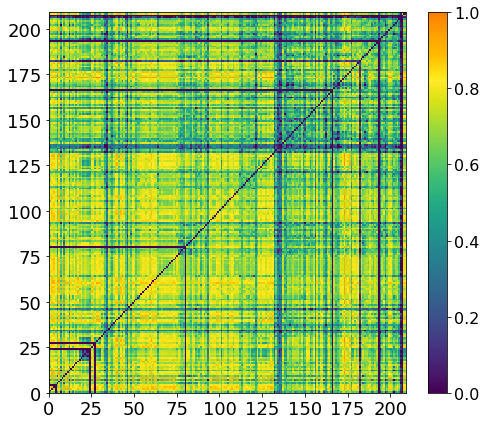

In [59]:
# Scores distribuition histogram
fig = plt.figure(figsize=(8,7))

ax = fig.add_subplot(111)
dist_mat = squareform(unlab.ravel())
N = dist_mat.shape[0]

top = cm.get_cmap('viridis', 512)
bottom = cm.get_cmap('Wistia', 512)

newcolors = np.vstack((top(np.linspace(0, 1, 812)),
                       bottom(np.linspace(0.2, 1, 180))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

plt.pcolormesh(dist_mat, cmap=  newcmp)

cbar = plt.colorbar(ax=ax)
plt.clim(0,1) 
cbar.ax.tick_params(labelsize=16) 
plt.xlim([0,N])
plt.ylim([0,N])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/deep_scores_ heatmap.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

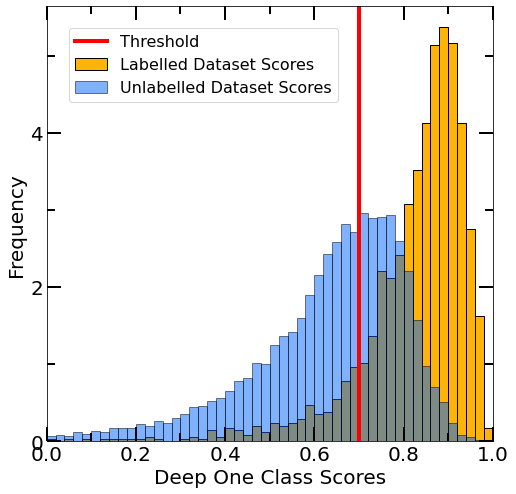

In [60]:
%matplotlib inline
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

_, bins , _ = plt.hist(lab.train_score.values, bins=50, ec='k', histtype='bar', density=True, alpha=1, color='#feb308', label='Labelled Dataset Scores')

_= plt.hist(unlab_final.test_score, bins=bins,density=True, ec='k',alpha=0.5, color='#0165fc', label='Unlabelled Dataset Scores')
#_= plt.hist(val.train_score, bins=bins,density=True, ec='k',alpha=0.5, color='red', label='Unlabelled Dataset Scores')
_ = plt.axvline(x=0.7, label='Threshold', c='r', linewidth=4)

plt.grid(False)
plt.xlim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0,1.001, 0.1)
major_ticks_y = np.arange(0, 6, 2)
minor_ticks_y = np.arange(0, 6, 1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

plt.legend(prop={'size': 16}, loc=[0.05, 0.78])
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/deep_scores_ histogram.png' ,rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

In [61]:
# Save the predictions for the pyrene possible pairs
pyr = np.concatenate([dictionary[dictionary.smiles1 == 'c1cc2ccc3cccc4ccc(c1)c2c34'].comb, dictionary[dictionary.smiles2 == 'c1cc2ccc3cccc4ccc(c1)c2c34'].comb])
pyra= unlab_final[unlab_final.Identifier.isin(pyr)]
pyr_dict=[]
for i in pyra.Identifier:
  pyr_dict.append(dict1[i])
pyrene_pairs = pd.concat([pd.DataFrame(pyr_dict, columns=['smiles1', 'smiles2']), pd.DataFrame(pyra.test_score.values, columns=['score'])], axis=1)
#pyrene_pairs.to_csv('/content/drive/My Drive/pyrene_pairs_scores_60_epochs.csv', index= False) 



#Visualize the results

The RDkit library is installed for enabling the visualizations. The molecules are visualized in pairs, e.g the firt two molecules compose the first co-crystal pair. The printed lists are separated into categories, according to the following criteria:\
1) No constrains\
2) Pairs after removing the solvents\
3) Pairs including one of the initial PAHs\
4) Pairs without solvents and heteroatoms\
5) Pairs including heteroatoms\
6) Pairs including 1,6 dicyanoanthracene, the most similar (Tanimoto Similarity) molecule to TCNQ (well known for the electronic properties)\
7) Pyrene-cocrystals (Pyrene was the most predicted co-former) 

In [62]:
# Install the RDKit library
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

# Append rdkit path to current python system path
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-07-07 00:08:19--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-07-07 00:08:19--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / done

## Package Plan ##

  environment location

In [77]:
# import rdkit libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [78]:
# Define a function to remove duplicates

def Remove(duplicate):
  seen = set()
  result = []
  for item in duplicate:
    if item not in seen:
        seen.add(item)
        result.append(item)
        
  return result

In [79]:
# List including the starting PAHs

initial_molecules=['c1ccc2cc3cc4cc5ccccc5cc4cc3cc2c1',                 # pentacene
                   'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34',               # picene
                   'c1ccc2c3ccccc3c4ccccc4c2c1',                       # triphenylene
                   'c1ccc2c(c1)ccc3ccccc23',                           # phenanthrene
                   'c1ccc2c(c1)c3cccc4cccc2c34',                       # fluoranthene
                   'c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27',           #coronene 
                   'c1ccc2c(c1)ccc1cc3cc4cc5c(ccc6ccccc65)cc4cc3cc12', #dibenzo-pentacene
                   'c1cc2ccc3ccc4ccc5ccc1c1c2c3c4c51']                #corannulene 

In [80]:
threshold = pd.DataFrame(unlab_final.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = unlab_final.sort_values(by = ['test_score'], ascending=True)
top_scored = unlab_final[unlab_final['test_score'] > threshold]
top_scored = top_scored.sort_values(by='test_score', ascending=False)
len(top_scored)

5434

In [81]:
top_scored = top_scored.drop_duplicates(subset='test_score')

In [82]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs

k2 = top_scored.Identifier
v2= top_scored.test_score
score_dict= {key:value for key, value in zip(k2, v2)}


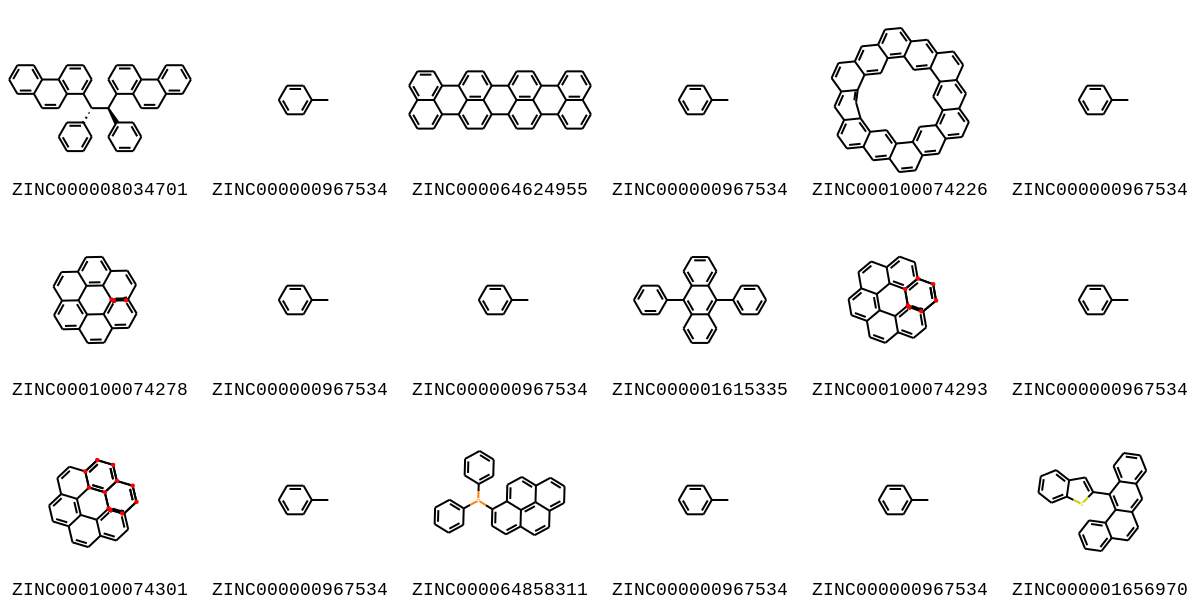

In [85]:
# Print a list with the ranking with no constrains
lista=[]
score=[]

for i in top_scored.Identifier[:9]:
  lista.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(lista)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
Draw.IPythonConsole.drawOptions.legendFontSize = 18
Draw.IPythonConsole.drawOptions.atomLabelFontSize = 12
Draw.IPythonConsole.drawOptions.atomLabelMinFontSize = 70

IPythonConsole.molSize = (500,500)

subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6, subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_rank1.png', "PNG")

In [86]:
score

[18130    0.977353
 Name: test_score, dtype: float32, 4309    0.963467
 Name: test_score, dtype: float32, 5410    0.954429
 Name: test_score, dtype: float32, 5590    0.951614
 Name: test_score, dtype: float32, 21113    0.949996
 Name: test_score, dtype: float32, 5769    0.949464
 Name: test_score, dtype: float32, 5947    0.943209
 Name: test_score, dtype: float32, 18619    0.941962
 Name: test_score, dtype: float32, 21132    0.94112
 Name: test_score, dtype: float32]

In [87]:
solvents = ['C1Cc2ccccc12', 'Brc1ccccc1', 'c1ccc2cnncc2c1', 'Cc1ccccc1', 'Cc1ccccc1C', 'Clc1ccccc1', 'Clc1ccccc1']
solvates=[]
for x in top_scored['Identifier']:
  if dict1[x][0] in solvents:
    solvates.append(x)
        
  if dict1[x][1] in solvents:
      solvates.append(x)

solvates = Remove(solvates)
len(solvates)
predictions1 = top_scored[~top_scored.Identifier.isin(solvates)]

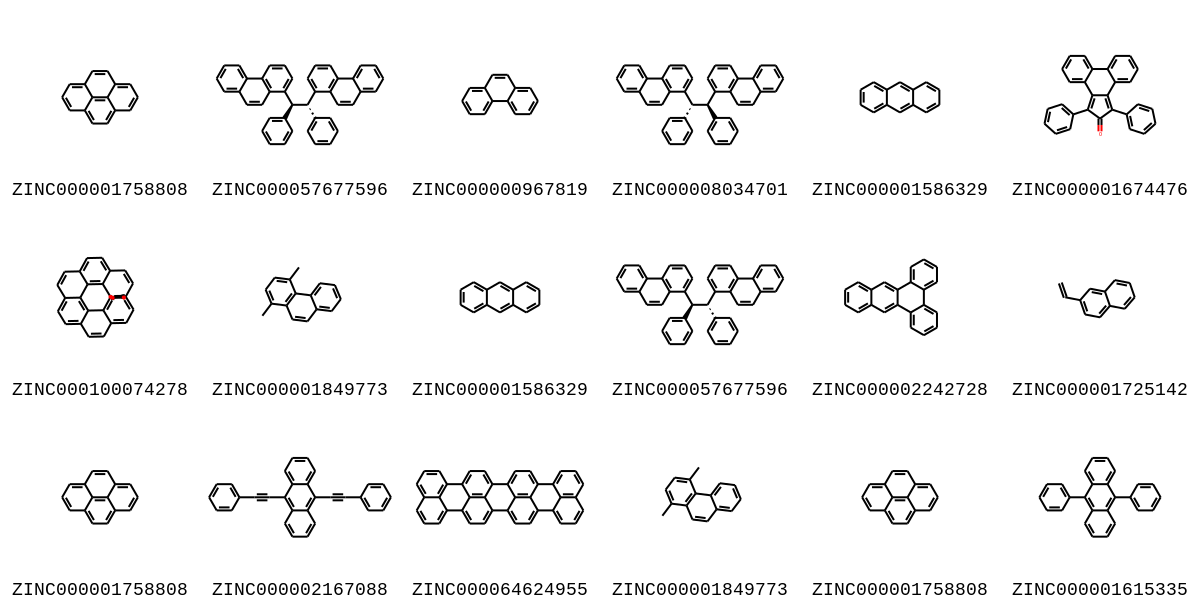

In [91]:
# Print a list with the ranking after removing the solvents
listaki=[]
score=[]

for i in predictions1.Identifier[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(listaki)
ar=ar.tolist()

import itertools
merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_rank_no_solvent.png', "PNG")

In [92]:
score

[1753    0.87476
 Name: test_score, dtype: float32, 7622    0.86833
 Name: test_score, dtype: float32, 10832    0.866855
 Name: test_score, dtype: float32, 5511    0.865739
 Name: test_score, dtype: float32, 10775    0.865127
 Name: test_score, dtype: float32, 15904    0.861535
 Name: test_score, dtype: float32, 1815    0.861517
 Name: test_score, dtype: float32, 4230    0.859206
 Name: test_score, dtype: float32, 1808    0.858919
 Name: test_score, dtype: float32]

In [93]:
# List with the combinations without heteroatoms
uf = pd.DataFrame(uf.values, columns=df.columns.values[1:])
het=pd.concat([uf_final.Identifier , uf.nHet.iloc[:,0], uf.nHet.iloc[:,1]], axis=1)

#het1 = het[het.nHet==0]
#het2 =het1[het1['nHet.1']!=0]

het3 = het[het.nHet.iloc[:,0]==0]
het4 =het3[het.nHet.iloc[:,1]==0]
#no_het = [x for x in predictions.Identifier.values if x in het2.Identifier.values]
het4
het = [x for x in predictions1.Identifier.values if x not in het4.Identifier.values]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


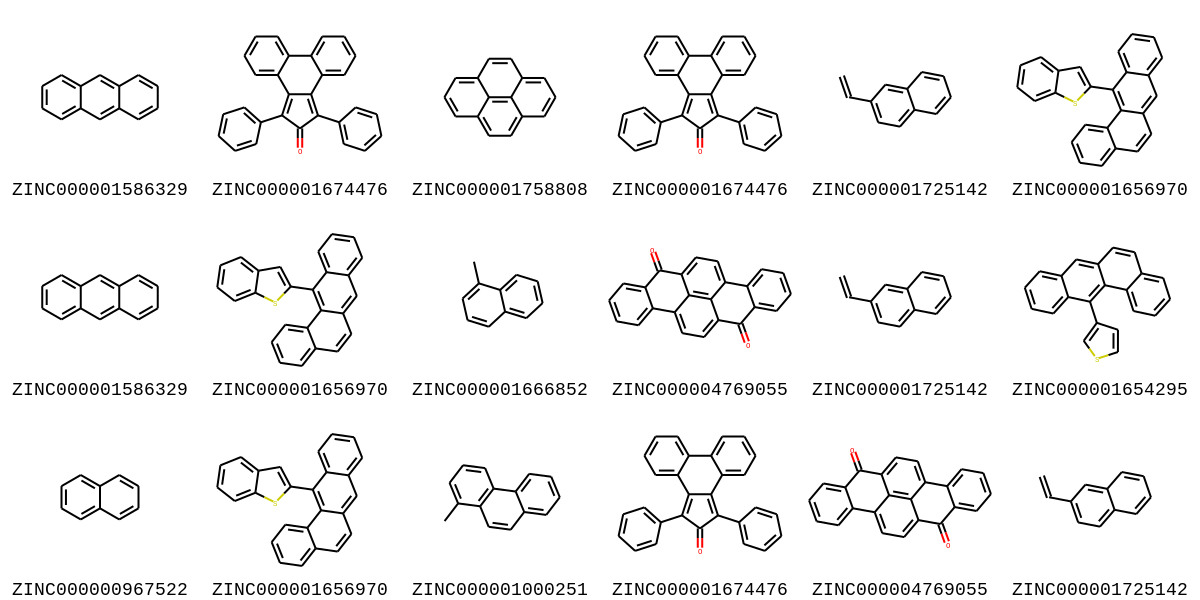

In [96]:
# List_3: A list with the ranking with heteroatoms
listaki=[]
score=[]

for i in het[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  
ar=np.array(listaki)
ar=ar.tolist()

import itertools
merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_with_heteroatoms.png', "PNG")

In [98]:
score

[10832    0.866855
 Name: test_score, dtype: float32, 1810    0.852839
 Name: test_score, dtype: float32, 20349    0.852438
 Name: test_score, dtype: float32, 10849    0.852426
 Name: test_score, dtype: float32, 13000    0.843962
 Name: test_score, dtype: float32, 20348    0.839252
 Name: test_score, dtype: float32, 7531    0.83891
 Name: test_score, dtype: float32, 8015    0.836132
 Name: test_score, dtype: float32, 17766    0.834436
 Name: test_score, dtype: float32]

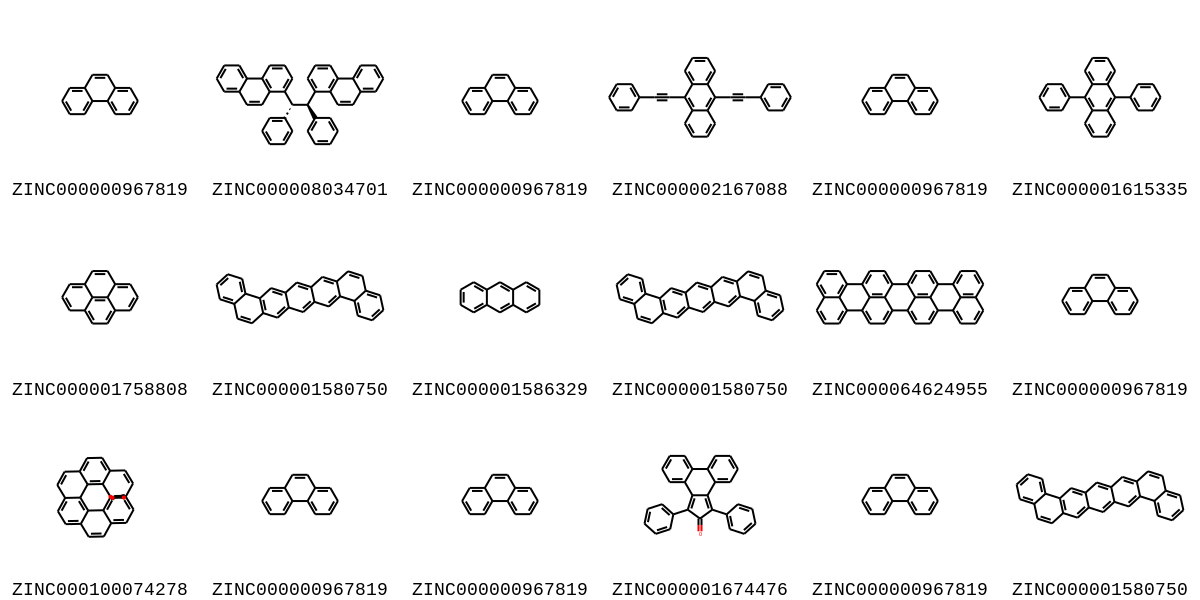

In [100]:
# List4: Combinations including the starting PAHs
one=[]
for x in predictions1['Identifier']:
  if dict1[x][0] in initial_molecules:
    one.append(x)
         
  else:
    if dict1[x][1] in initial_molecules:
      one.append(x)
one=Remove(one)
listaki=[]
score=[]

for i in one[:9]:
  listaki.append(dict1[i])
  score.append(top_scored[top_scored.Identifier ==i].test_score)
ar=np.array(listaki)
ar=ar.tolist()

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_initial_PAHs.png', "PNG")

In [101]:
score

[7622    0.86833
 Name: test_score, dtype: float32, 7687    0.848832
 Name: test_score, dtype: float32, 7680    0.848662
 Name: test_score, dtype: float32, 1835    0.847268
 Name: test_score, dtype: float32, 10857    0.844993
 Name: test_score, dtype: float32, 4176    0.839704
 Name: test_score, dtype: float32, 5457    0.837458
 Name: test_score, dtype: float32, 7682    0.829854
 Name: test_score, dtype: float32, 7707    0.827393
 Name: test_score, dtype: float32]

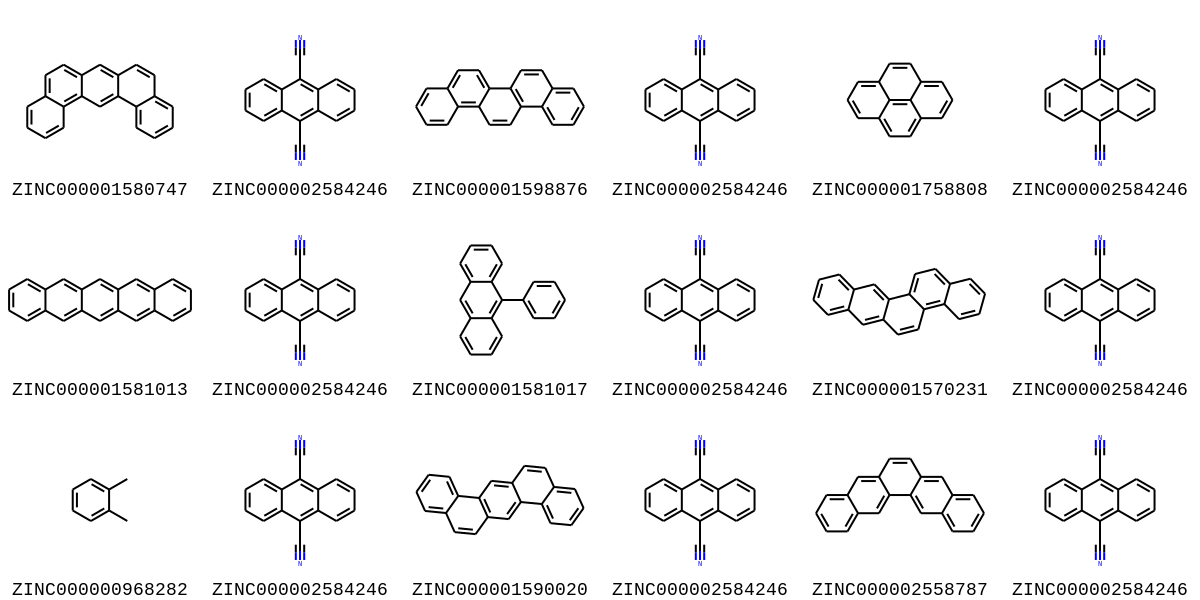

In [102]:
# Show all the combinatios with  9,10-Anthracenedicarbonitrile 
dicyano=[]
for x in top_scored.Identifier:
  if dict1[x][0] == 'N#Cc1c2ccccc2c(C#N)c3ccccc13':     # if you want to check other molecules just change the two smiles here
    dicyano.append(x)        
  if dict1[x][1] == 'N#Cc1c2ccccc2c(C#N)c3ccccc13':     # and here
    dicyano.append(x)

dicyano= Remove(dicyano)    

listaki=[]
score=[]

for i in dicyano[:9]:                     # select the number of the predictions you want to see
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools
#IPythonConsole.molSize = (500,500)

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]



img=Draw.MolsToGridImage(subms,molsPerRow=6,legends=[zinc_dict[x] for x in merged], subImgSize=(200,200))#, options=options)
#Draw.IPythonConsole.drawOptions.atomLabelFontSize = 600
img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_dicyano.svg', "PNG")



In [103]:
score

[10240    0.729367
 Name: test_score, dtype: float32, 11276    0.723957
 Name: test_score, dtype: float32, 1816    0.722933
 Name: test_score, dtype: float32, 10541    0.713185
 Name: test_score, dtype: float32, 10690    0.70491
 Name: test_score, dtype: float32, 10088    0.70467
 Name: test_score, dtype: float32, 21220    0.703127
 Name: test_score, dtype: float32, 11131    0.701557
 Name: test_score, dtype: float32, 16666    0.701207
 Name: test_score, dtype: float32]

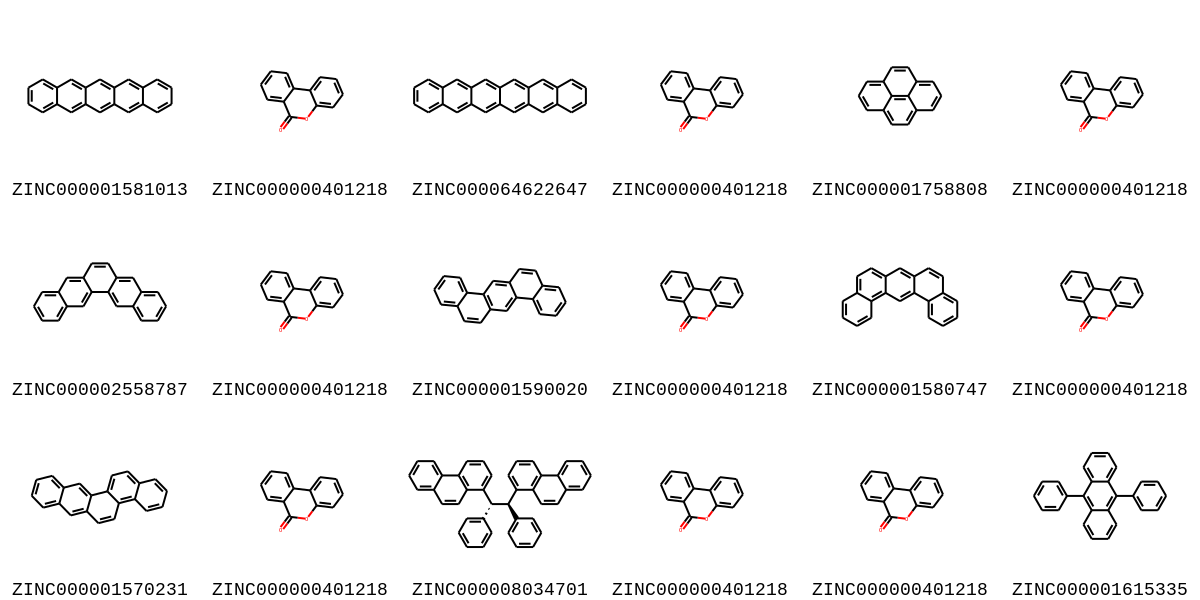

In [105]:
mol2=[]
for x in predictions1.Identifier:
  if dict1[x][0] == 'O=C1Oc2ccccc2c3ccccc13':     # if you want to check other molecules just change the two smiles here
    mol2.append(x)        
  if dict1[x][1] == 'O=C1Oc2ccccc2c3ccccc13':     # and here
    mol2.append(x)

mol2 = Remove(mol2)    
listaki=[]
score=[]

for i in mol2[:9]:                     # select the number of the predictions you want to see
  score.append(top_scored[top_scored.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]

img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_initial_benzochromenone.png', "PNG")

In [106]:
score

[10523    0.812863
 Name: test_score, dtype: float32, 18538    0.81231
 Name: test_score, dtype: float32, 1798    0.803559
 Name: test_score, dtype: float32, 16648    0.79836
 Name: test_score, dtype: float32, 11113    0.797104
 Name: test_score, dtype: float32, 10222    0.787948
 Name: test_score, dtype: float32, 10070    0.782687
 Name: test_score, dtype: float32, 18128    0.781193
 Name: test_score, dtype: float32, 21042    0.780904
 Name: test_score, dtype: float32]

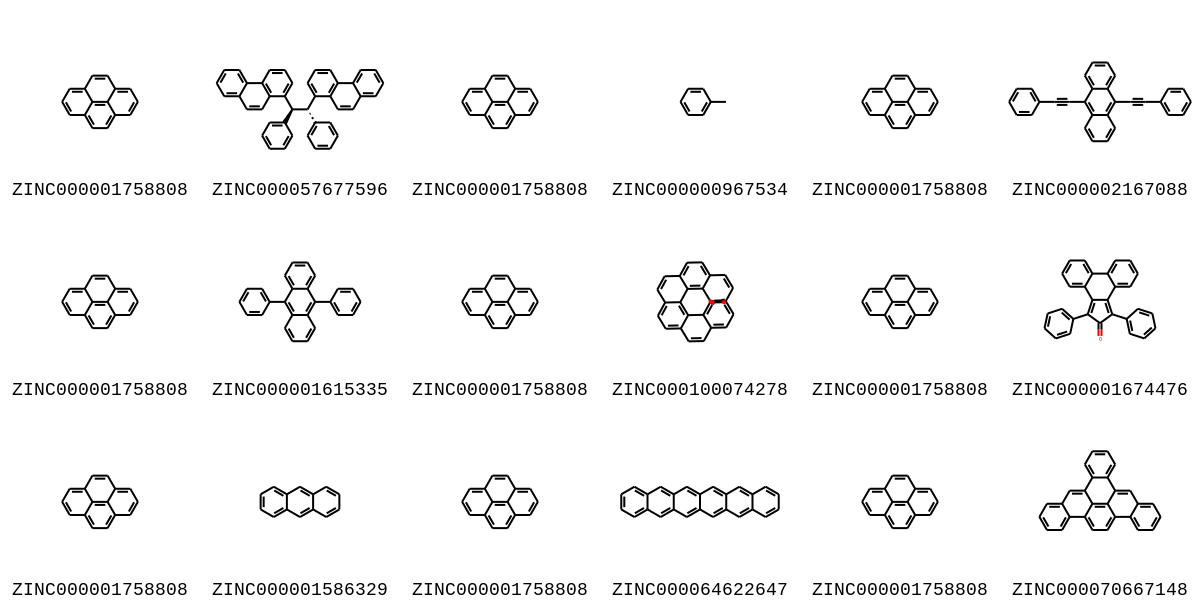

In [113]:
# Show all the combinatios with pyrene
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

options = DrawingOptions()
options.legendFontSize = 18

pyrene=[]

for x in top_scored.Identifier:
  if dict1[x][0] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    pyrene.append(x)        
  if dict1[x][1] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    pyrene.append(x)

pyrene= Remove(pyrene)    

listaki=[]
pyrene_score=[]


for i in pyrene[:9]:                      # select the number of the predictions you want to see
  pyrene_score.append(score_dict[i]) # predictions[predictions.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))

subms = [Chem.MolFromSmiles(x) for x in merged]
pyrene_img=Draw.MolsToGridImage(subms,molsPerRow=6,subImgSize=(200,200), legends=[zinc_dict[x] for x in merged] )
pyrene_img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_pyrene.png', "PNG")

In [109]:
pyrene_score

[0.8747602701187134,
 0.8706201314926147,
 0.861517071723938,
 0.8589191436767578,
 0.8560476303100586,
 0.8528392910957336,
 0.8507953882217407,
 0.850426197052002,
 0.8500269651412964]

In [238]:
# Count the popularity
predictions = list(top_scored['Identifier'])
listaki=[]
for i in predictions[:]:
  listaki.append(dict1[i])
data1 = pd.concat([pd.DataFrame(listaki)[:].iloc[:, 0], pd.DataFrame(listaki)[:].iloc[:, 1]])
data1 = pd.DataFrame(listaki)[:].iloc[:, 0]
data1 = [x for x in data1.values if x not in solvents]

data1= pd.DataFrame(data1, columns=['a'])
dat1 = pd.DataFrame(data1['a'].value_counts())[:10]

dat1

,a
c1cc2ccc3cccc4ccc(c1)c2c34,141
c1ccc2c(c1)ccc3ccc4ccccc4c23,115
C1=Cc2cccc3cccc1c23,113
c1cc2cccc3c4cccc5cccc(c(c1)c23)c45,109
c1ccc2c(c1)ccc3ccccc23,100
Cc1cccc2cccc(C)c12,95
c1ccc2cc3ccccc3cc2c1,91
c1ccc2c(c1)c3cccc4ccc5cccc2c5c34,88
c1ccc2ccccc2c1,86
Cc1cccc2c1ccc3ccccc23,84


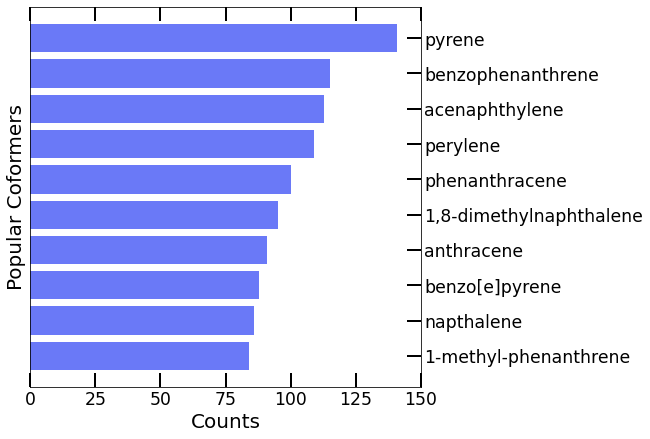

In [288]:
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(0,150)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')



x = ['pyrene',  'benzophenanthrene', 'acenaphthylene', 'perylene', 'phenanthracene',   '1,8-dimethylnaphthalene', 'anthracene', 
       'benzo[e]pyrene', 'napthalene', '1-methyl-phenanthrene']

energy = dat1.a
x_pos = [i for i, _ in enumerate(x)]

idx = np.asarray([i for i in range(len(x))])                 
#ax.set_yticks(idx)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_right()

plt.barh(x_pos, energy, color='#6a79f7')
plt.gca().invert_yaxis()
plt.ylabel("Popular Coformers",fontsize=20, fontweight='normal')
plt.xlabel("Counts" ,fontsize=20,  fontweight='normal')

plt.yticks(x_pos, x)

plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/deep_popular.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

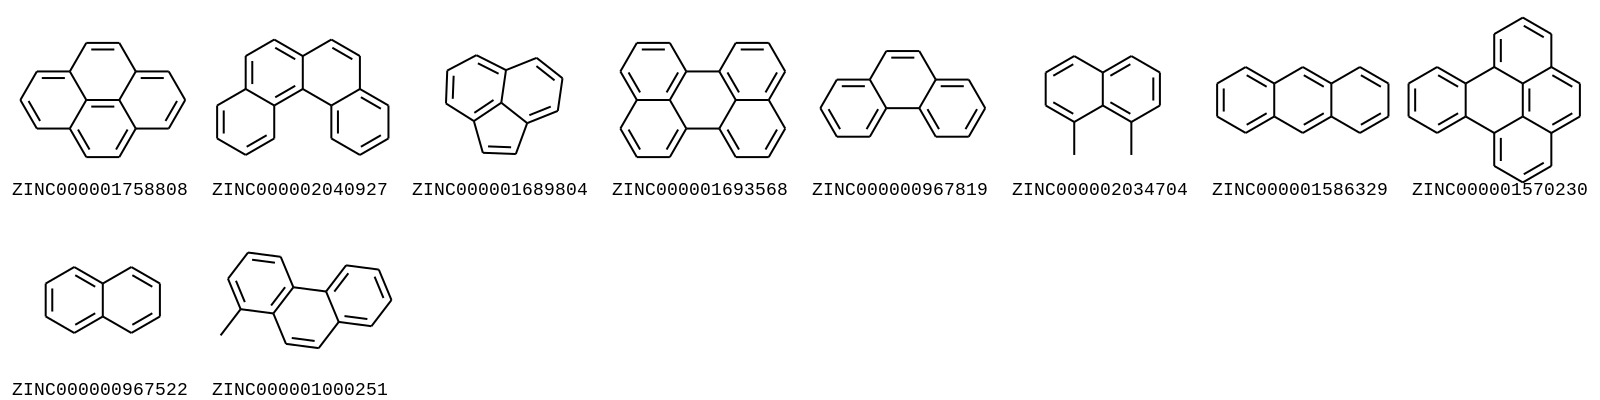

In [282]:
# Visualize the popular co-formers
smi= dat1.index 
subms1 = [Chem.MolFromSmiles(x) for x in smi]


img=Draw.MolsToGridImage(subms1[:],molsPerRow=8,subImgSize=(200,200), legends=[zinc_dict[x] for x in smi])
img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_popular_top.png', "PNG")

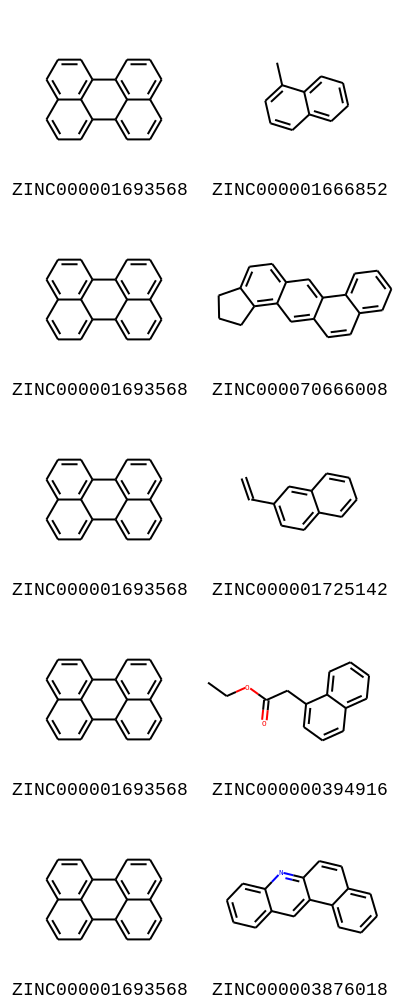

In [255]:
# Show all the combinatios with pyrene
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions

options = DrawingOptions()
options.legendFontSize = 18

pyrene=[]
#pred=[x for x in predictions1.Identifier if x not in ]

for x in predictions1.Identifier[:]:
  if dict1[x][0] == 'c1cc2cccc3c4cccc5cccc(c(c1)c23)c45':
    pyrene.append(x)        
  #if dict1[x][1] == 'c1ccc2c(c1)ccc3ccc4ccccc4c23':
   # pyrene.append(x)

pyrene= Remove(pyrene)    

listaki=[]
pyrene_score=[]


for i in pyrene[1:6]:                      # select the number of the predictions you want to see
  pyrene_score.append(score_dict[i]) # predictions[predictions.Identifier ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
pyrene_img=Draw.MolsToGridImage(subms,molsPerRow=2,subImgSize=(200,200), legends=[zinc_dict[x] for x in merged] )
pyrene_img#.save('/content/drive/My Drive/cocrystal_design-master/figures/deep_popular4.png', "PNG")

In [ ]:
pyrene=[]
for x in predictions[:]:
  if dict1[x][0] == 'c1cc2ccc3cccc4ccc(c1)c2c34':     # if you want to check other molecules just change the two smiles here
    pyrene.append(x)        
  if dict1[x][1] == 'c1cc2ccc3cccc4ccc(c1)c2c34':     # and here
    pyrene.append(x)

pyrene= Remove(pyrene)    
listaki2=[]
pyrene_score=[]

for i in pyrene[:]:       # select the number of the predictions you want to see
  pyrene_score.append(score_dict[i])
  listaki2.append(dict1[i])
   
ar=np.array(listaki2)
ar=ar.tolist()

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
pyrene_img = Draw.MolsToGridImage(subms,molsPerRow=2 ,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


In [ ]:
df_pyrene  = pd.concat([pd.DataFrame(pyrene, columns=['combination_id']), 
                       pd.DataFrame(pyrene_score, columns=['score'])], axis=1) #  pd.DataFrame(zinc_id, columns=['zinc_id1']), pd.DataFrame(zinc_id2, columns=['zinc_id2']), 

In [ ]:
# Set the HTML table properties
td_props = [
  ('font-size', '20px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('border', '1px solid black')
  ]

th_props = [
  ('font-size', '18px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#b6ffbb'),
  ('border', '10px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

In [ ]:
num_of_comb= len(pyrene)
listaki_2 = []
for i in range(num_of_comb):
    y = i * 200
    listaki_2.append(pyrene_img.crop((0, y, 400, y + 200)))

,combination_id,score,molecular pairs
0,comb1754,0.878237,
1,comb1753,0.878237,
2,comb1751,0.878237,
3,comb1801,0.870528,
4,comb1816,0.858470,

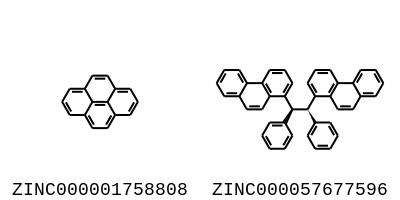
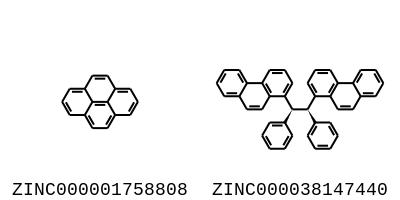
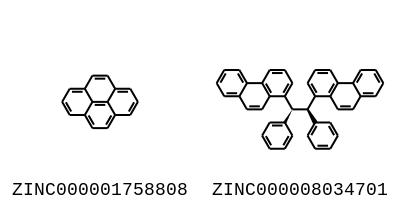
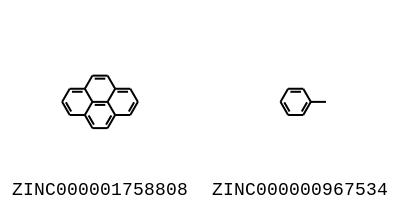
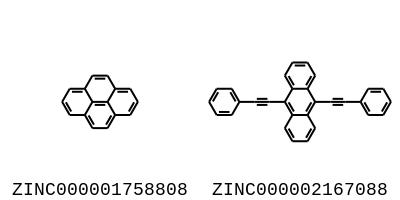

In [ ]:
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
images = listaki_2
df_pyrene['molecular pairs'] = images

# convert your links to html tags 
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

html = (df_pyrene.iloc[:,:].head().style
               .set_table_styles(styles)
               .format({'molecular pairs': image_formatter})
               .render())
HTML(html)

#Interpretability

In [197]:
threshold = pd.DataFrame(unlab_final.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = unlab_final.sort_values(by = ['test_score'], ascending=True)
top_scored = unlab_final[unlab_final['test_score'] > threshold]
top_scored = top_scored.sort_values(by='test_score', ascending=False)
len(top_scored)

5434

In [198]:
df1=dataset1.iloc[:,2:]
df2=dataset2.iloc[:,2:]
df_concat = pd.concat([df1, df2])
df1 = df1.fillna(df_concat.mean())

df2 = df2.fillna(df_concat.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]
df = concat_bidirectional(df1,df2)


In [199]:
uf1=pd.concat([final_1, final_2], axis =1)
comb=[]
for i in range(1,final_1.shape[0]+1):
  comb.append('comb%s' % i)
uf_final1=pd.concat([pd.DataFrame(comb, columns=['comb']),final_1, final_2 ], axis=1)
#uf_final1

In [ ]:
test_score = unlab_final #pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabelled_deep.csv')
test_score['test_score'][test_score['test_score'] < 0] = 0
unlab = pd.concat([pd.DataFrame(uf_final1.comb.values, columns=['Identifier']), pd.DataFrame(test_score.test_score, columns=['test_score'])], axis=1)
combinations = unlab[unlab.test_score> 0.7].Identifier.values
test = uf_final1[uf_final1.comb.isin(combinations)]
test_all =  uf_final1[~uf_final1.comb.isin(combinations)]

In [215]:
def feature(feat):
  data = pd.concat([pd.DataFrame(df[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(df[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data['label'] = 'labeled'

  data1 = pd.concat([pd.DataFrame(test[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(test[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data1['label'] = 'inliers'

  data2 = pd.concat([pd.DataFrame(test_all[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(test_all[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data2['label'] = 'unlabeled'

  data_all = pd.concat([data, data1, data2])
  return data_all

data_all = feature('Pol')

Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


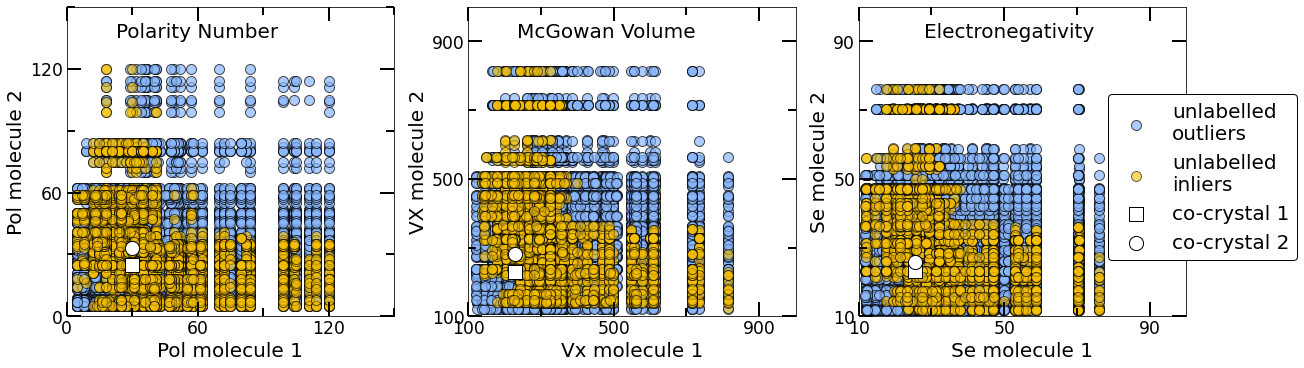

In [221]:
import matplotlib.font_manager
from matplotlib import cm
from scipy.stats import gaussian_kde
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
#newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
data_all = feature('Pol')
data = data_all[data_all.label == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
ax0.scatter(data.x, data.y,s=100, alpha=0.7, color='#8ab8fe', edgecolors='black' )#, label = 'Unlabelled')
ax0.text(0.15, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,   s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
# Experomental Compounds
ax0.scatter(30, 25, color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
ax0.scatter(30, 33, color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(0, 150)
ax0.set_ylim(0, 150)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction = 'in')
major_ticks_x = np.arange(0, 150.1, 60)
minor_ticks_x = np.arange(0, 150.1, 30)
major_ticks_y = np.arange(0, 150.1, 60)
minor_ticks_y = np.arange(0, 150.1, 30)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)

#Volume
data_all = feature('Vx')
data = data_all[data_all.label  == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']

#x1y1 = np.vstack([x1,y1])
#z = gaussian_kde(x1y1)(x1y1)
ax1.scatter(data.x, data.y,s=100, alpha=0.7, color='#8ab8fe', edgecolors='black')
ax1.scatter(x1, y1,   s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers') #, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.15, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
# Experomental COmpounds
ax1.scatter(227.911, 228.115, color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
ax1.scatter(227.911, 281.964, color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(100, 1000)
ax1.set_ylim(100, 1000)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True , direction = 'in')
major_ticks_x = np.arange(100, 1000.1, 400)
minor_ticks_x = np.arange(100, 1000.1, 200)
major_ticks_y = np.arange(100, 1000.1, 400)
minor_ticks_y = np.arange(100, 1000.1, 200)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

#Electronic
data_all = feature('Se')
data = data_all[data_all.label  == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
ax2.scatter(data.x, data.y,s=100, alpha=0.7, color='#8ab8fe', edgecolors='black', label = 'unlabelled\noutliers' )
ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='unlabelled\ninliers')

ax2.text(0.2, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
ax2.scatter(25.418, 23.183, color='white', s=200, label='co-crystal 1',marker = 's', edgecolors='black')
ax2.scatter(25.418, 25.854, color='white', s=200,marker = 'o', label='co-crystal 2',edgecolors='black')         
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(10, 100)
ax2.set_ylim(10, 100)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100, 40)
minor_ticks_x = np.arange(10, 100, 20)
major_ticks_y = np.arange(10, 100, 40)
minor_ticks_y = np.arange(10, 100, 20)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)

ax2.set_yticks(minor_ticks_y, minor=True)
#ax2.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
plt.legend( bbox_to_anchor= (0.73, 0.75), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
#plt.savefig('/content/drive/My Drive/cocrystal_design-master/figures/figure9_unlab_new.png', dpi=600)